# SVM with linear kernel

The goal of this notebook is to find the best parameters for linear kernel. We also want to check if the parameters depend on stock.

Linear kernel is a function: $\langle x, x'\rangle$.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '2051', '4481', '3107', '1243', '11234'][:5]

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 4496
Testing set length for 10795: 1498
Cross-validation set length for 10795: 1498
Training set length for 12098: 3592
Testing set length for 12098: 1197
Cross-validation set length for 12098: 1197
Training set length for 11618: 3792
Testing set length for 11618: 1264
Cross-validation set length for 11618: 1264
Training set length for 2051: 3635
Testing set length for 2051: 1211
Cross-validation set length for 2051: 1211
Training set length for 4481: 3903
Testing set length for 4481: 1301
Cross-validation set length for 4481: 1301


In [3]:
dfs[stocks[0]].head(5)

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-13 10:57:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1489.0, 1874.0), (1490.0, 4866.0), (1491.0, ...",1488.0,1489.0,1488.5,1874.0,800.0,1.0,-0.401645
2013-09-13 10:59:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 220.0), (1491.0, 3642.0), (1492.0, 5...",1488.0,1490.0,1489.0,220.0,3967.0,1.0,0.894913
2013-09-13 11:00:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1491.0, 905.0), (1492.0, 5591.0), (1493.0, 6...",1489.0,1491.0,1490.0,905.0,2807.0,1.0,0.512392
2013-09-13 11:01:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1492.0, 4077.0), (1493.0, 6616.0), (1494.0, ...",1490.0,1492.0,1491.0,4077.0,1563.0,0.0,-0.445745
2013-09-13 11:03:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 1738.0), (1491.0, 4491.0), (1492.0, ...",1488.0,1490.0,1489.0,1738.0,4642.0,1.0,0.455172


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults. For the **linear** kernel according to documentation it's worth to check only the **C** parameter.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

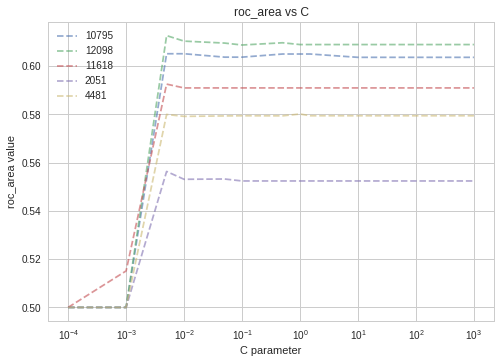

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100, 110, 1000]

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'linear', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.6)
    df_css[s] = df_cs
plt.legend()
plt.xlabel('C parameter')
plt.ylabel('roc_area value')
plt.title('roc_area vs C')

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.005
For 12098 the best is 0.005
For 11618 the best is 0.005
For 2051 the best is 0.005
For 4481 the best is 1.0


In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.1051921707994583
For 12098 the diff between best and worst 0.11270883655394526
For 11618 the diff between best and worst 0.09259106260781169
For 2051 the diff between best and worst 0.05636924604581883
For 4481 the diff between best and worst 0.08019436759594234


# Results

We compare results of SVMs with the best choice of **C** parameter against the logistic regression and SVM with defaults.

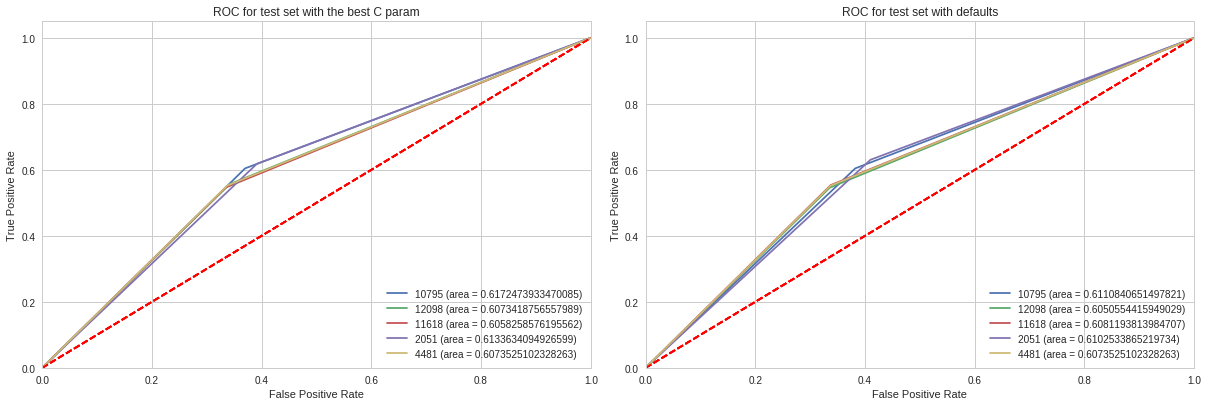

In [8]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['linear-default'] = np.zeros(len(stocks))
df_results['linear-tunned'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with defaults')
    df_results['linear-default'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

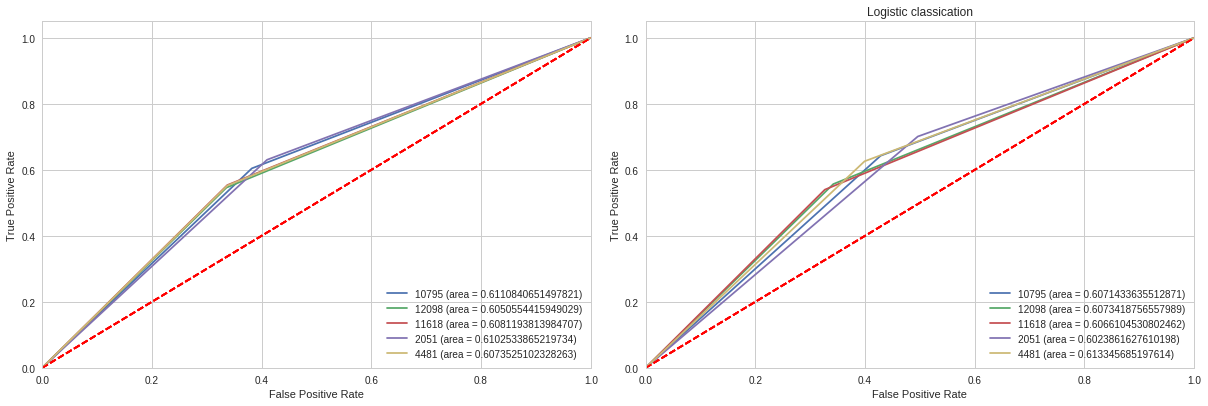

In [10]:
plt.subplot(121)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s)
    df_results['linear-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(df_test, reg_log, stock=s, title='Logistic classication')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [11]:
df_results

,logistic,linear-default,linear-tunned
10795,0.607143,0.611084,0.611084
12098,0.607342,0.605055,0.605055
11618,0.606610,0.608119,0.608119
2051,0.602386,0.610253,0.610253
4481,0.613346,0.607353,0.607353


# Conclusions

In our case SVM with **linear** kernel works the best for small values of **C** parameter. Choice of this parameter should vary between stocks - usually value between 0.005 - 0.5 is a good choice. It means that being tolerant to misclassifications makes our classificator to yield better results.

The results for SVM with default **C** parameter for testing set are sometimes better, than for SVMs with parameter **C** learned on cross-validation set, but still - the default value of **C** is also small.

Compared to logistic regression we have small improvement - for stock **2051** it's even a very good improvement. For stock **11618** and **4481** our results are a bit worse.